# Bias correct CESM2 wind speeds to ERA5 using stress

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range

Equation: 

$\tau = \rho C_D U_z |U_z| = \rho C_d U^2 = \rho C_d (u^2 + v^2)$ OR

$ \tau_x = \rho \cdot C_d \cdot u \cdot  \sqrt{u^2 + v^2}$

$ \tau_y = \rho \cdot C_d \cdot v \cdot \sqrt{u^2 + v^2}$

Write out sea ice ($C_{di}$) and ocean ($C_{do}$) drag coefficients and calculate:

$\tau_{ERA5} = \tau_{CESM2}$

$(C_{di ERA5} + C_{do ERA5}) (u_{ERA5}^2 + v_{ERA5}^2) = (C_{di CESM2} + C_{do CESM2}) (u_{CESM2}^2 + v_{CESM2}^2 + bias)$

$\frac{C_{di ERA5} + C_{do ERA5}}{C_{di CESM2} + C_{do CESM2}} (u_{ERA5}^2 + v_{ERA5}^2) = u_{CESM2}^2 + v_{CESM2}^2 + bias$

$bias = \frac{C_{di ERA5} + C_{do ERA5}}{C_{di CESM2} + C_{do CESM2}} (u_{ERA5}^2 + v_{ERA5}^2) - u_{CESM2}^2 - v_{CESM2}^2$

Or alternatively, I could read in wind stress from ERA5 forced experiment and from CESM2 forced experiment: utau_oce, vtau_oce (taum is already written to file)

$C_D$ --- bulk transfer coefficient of momentum


Steps:
- Mean surface air density for ERA5 and CESM2 experiments
- Mean of ERA5 u10 and v10 over the timeseries
- Ensemble mean of CESM2 U and V over the timeseries
- Regrid ERA5 and CESM2 velocities onto the NEMO grid
- Drag coefficients for an experiment with ERA5 and for an experiment with CESM2

OR
- Mean of ERA5 experiment taum
- Mean of CESM2 experiment taum
- Stress bias = difference between these two
- Then, $stress bias = \rho_{air} C_D (u^2 + v^2 + wind bias)$ $\rightarrow$ $wind bias = \frac{stress bias}{\rho_o C_D} - u^2 - v^2$

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
# cesm2_u = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_UBOT_y1979.nc').mean(dim='time')
# cesm2_v = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_VBOT_y1979.nc').mean(dim='time')
# cesm2_u10 = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_U10x_y1979.nc').mean(dim='time')
# cesm2_v10 = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_U10y_y1979.nc').mean(dim='time')
# era5_u  = xr.open_dataset(f'{base_dir}ERA5-forcing/daily/files/processed/u10_time_y1979.nc').mean(dim='time')
# era5_v  = xr.open_dataset(f'{base_dir}ERA5-forcing/daily/files/processed/v10_time_y1979.nc').mean(dim='time')

# era5_ds  = xr.open_dataset(f'{base_dir}output/ERA5_test10_writedrag/files0/eANT025.L121_1m_19790101_19791231_SBC.nc').mean(dim='time_counter')
cesm2era5 = xr.open_dataset(f'{base_dir}output/CESM2_hist8/files0/eANT025.L121_1m_19790101_19791231_SBC.nc').mean(dim='time_counter')
cesm2u10  = xr.open_dataset(f'{base_dir}output/CESM2_hist7/files0/eANT025.L121_1m_19790101_19791231_SBC.nc').mean(dim='time_counter')
cesm2_ds  = xr.open_dataset(f'{base_dir}output/CESM2_hist6_writedrag/files0/eANT025.L121_1m_19790101_19791231_SBC.nc').mean(dim='time_counter')
# cesm2_ds2 = xr.open_dataset(f'{base_dir}output/CESM2_hist6_writedrag/files0/eANT025.L121_1m_19800101_19801231_SBC.nc').mean(dim='time_counter')

## Calculate
- air density differences don't change strongly year-to-year (~0.02 on values ranging from 1.25-1.35). Ocean drag changes by ~5e-5 for values between 1.0e-3 to 1.6e-3, so interannual variation is less than the spatial variation within a year. But, could there still be significant drift over time? A bit hard to know what to do about all of that. 
- 

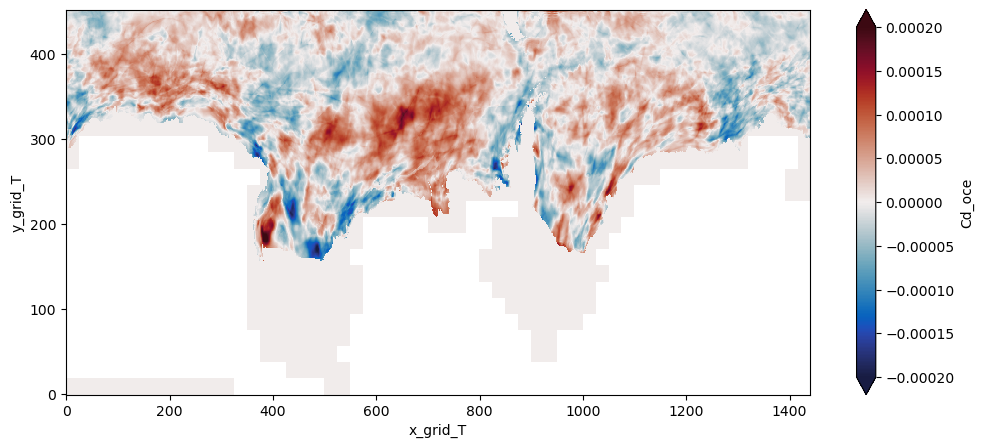

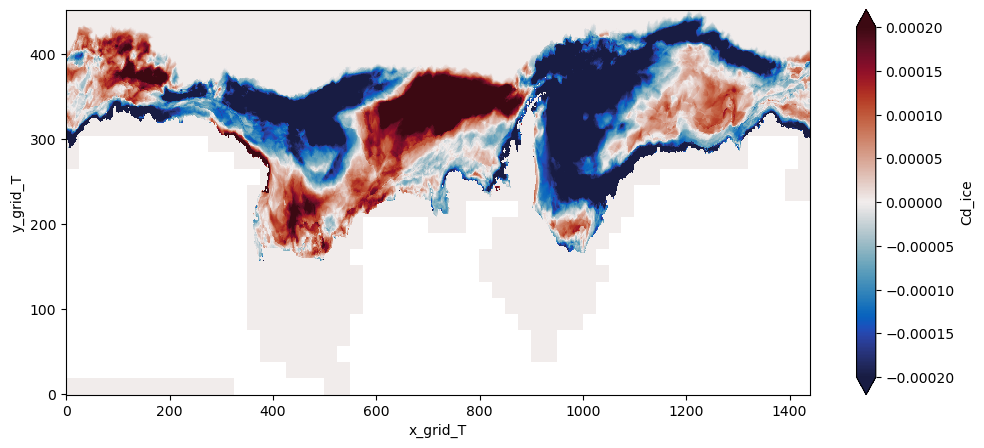

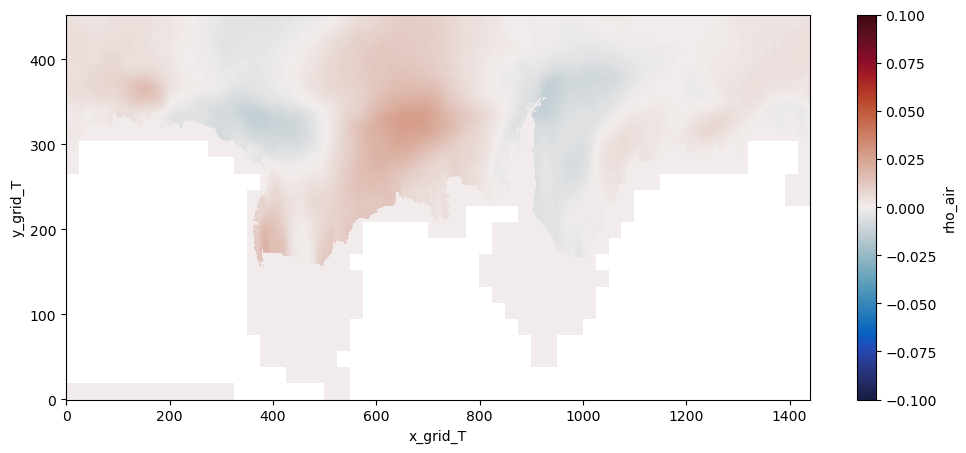

In [53]:
(cesm2_ds.Cd_oce - cesm2_ds2.Cd_oce).plot(figsize=(12,5), vmin=-2e-4, vmax=2e-4, cmap=cmocean.cm.balance)
(cesm2_ds.Cd_ice - cesm2_ds2.Cd_ice).plot(figsize=(12,5), vmin=-2e-4, vmax=2e-4, cmap=cmocean.cm.balance)
(cesm2_ds.rho_air - cesm2_ds2.rho_air).plot(figsize=(12,5), vmin=-0.1, vmax=0.1, cmap=cmocean.cm.balance)

In [ ]:
Cd_cesm2_comb = xr.where(cesm2_ice.siconc>=0.1, 1.4e-3, Cd_cesm2)

In [33]:
rho_air_cesm2 = cesm2_ds.rho_air 
Cd_cesm2      = cesm2_ds.Cd_oce # momentum drag coefficient (will be a 2d field)
rho_air_era5  = era5_ds.rho_air 
Cd_era5       = era5_ds.Cd_oce # momentum drag coefficient (will be a 2d field)

# see if I can recreate wind forcing from stress and constants (i.e. whether I'm using the equations correctly)
cesm2_wind_estimate = np.sqrt(cesm2_ds.taum/(rho_air_cesm2*Cd_cesm2))
era5_wind_estimate  = np.sqrt(era5_ds.taum/(rho_air_era5*Cd_era5))

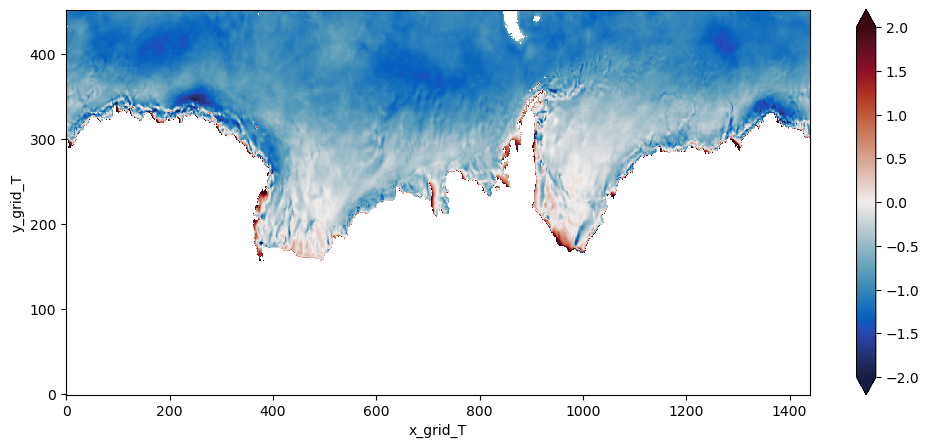

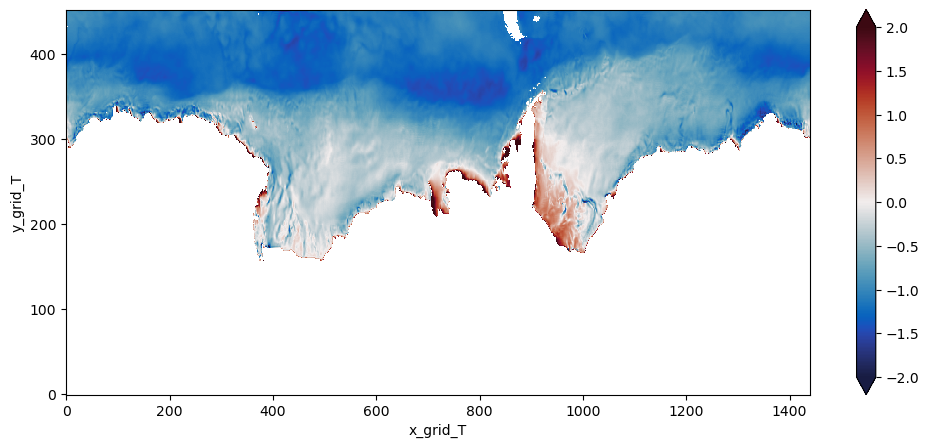

In [34]:
(cesm2_ds.windsp - cesm2_wind_estimate).plot(figsize=(12,5), vmin=-2, vmax=2, cmap=cmocean.cm.balance)
(era5_ds.windsp - era5_wind_estimate).plot(figsize=(12,5), vmin=-2, vmax=2, cmap=cmocean.cm.balance)

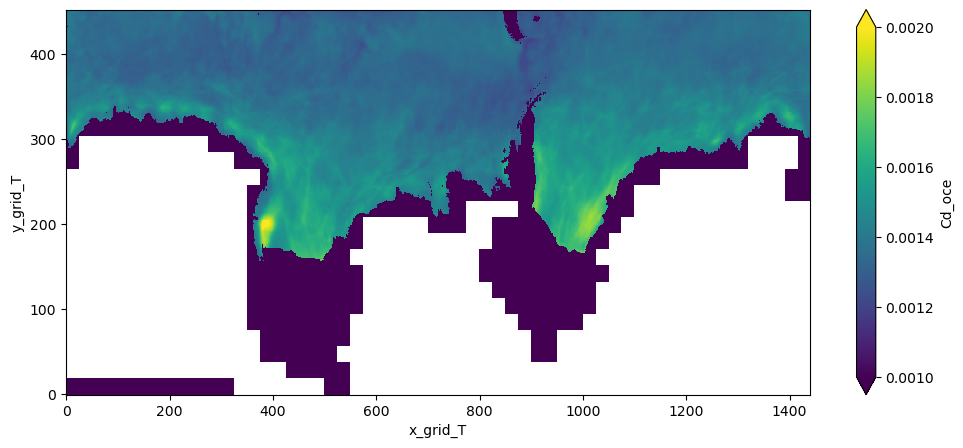

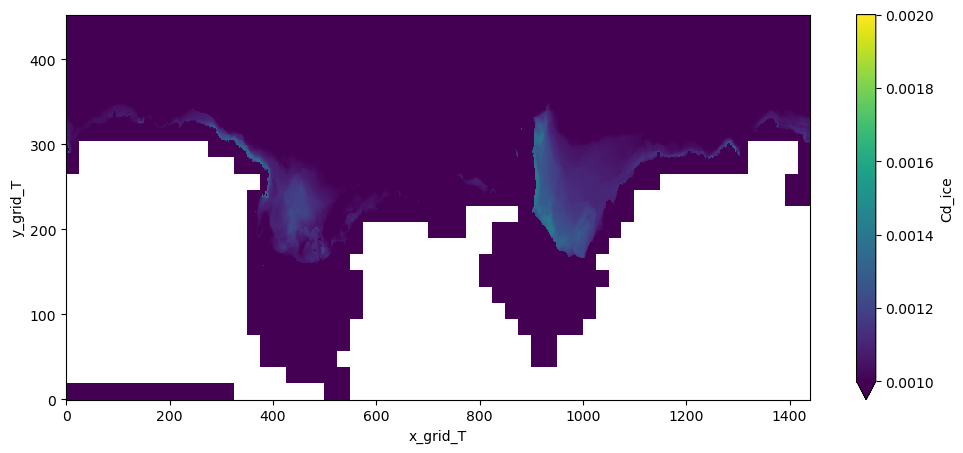

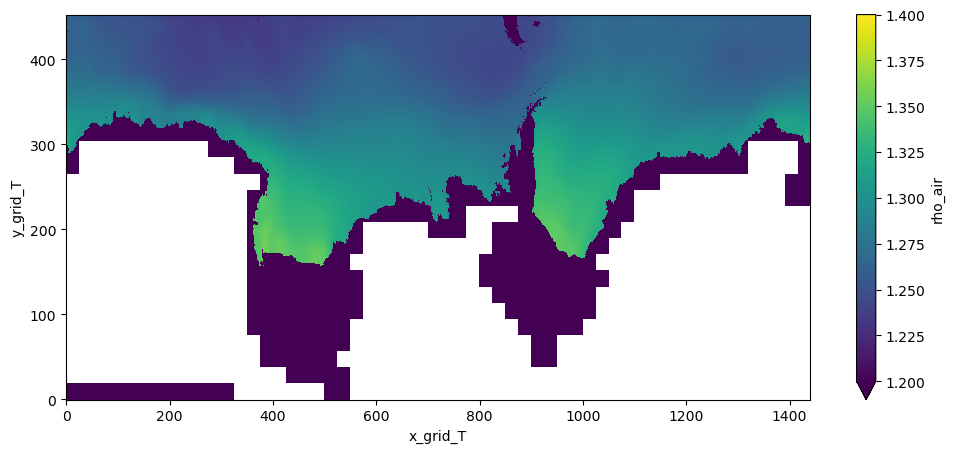

In [16]:
cesm2_ds.Cd_oce.plot(figsize=(12,5), vmin=10e-4, vmax=20e-4)
cesm2_ds.Cd_ice.plot(figsize=(12,5), vmin=10e-4, vmax=20e-4)
cesm2_ds.rho_air.plot(figsize=(12,5), vmin=1.2, vmax=1.4)

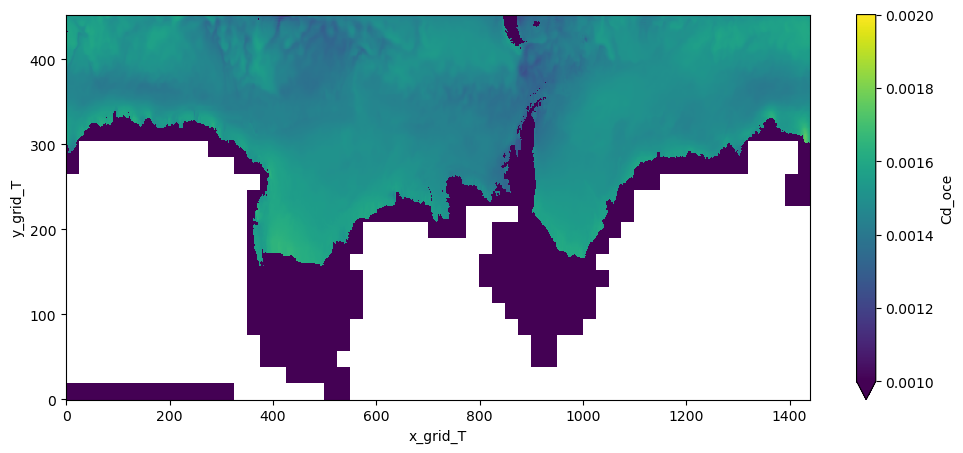

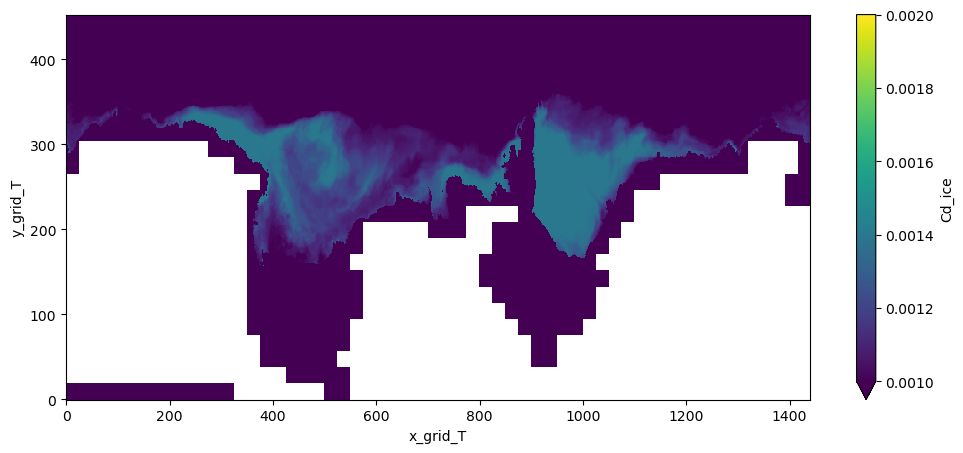

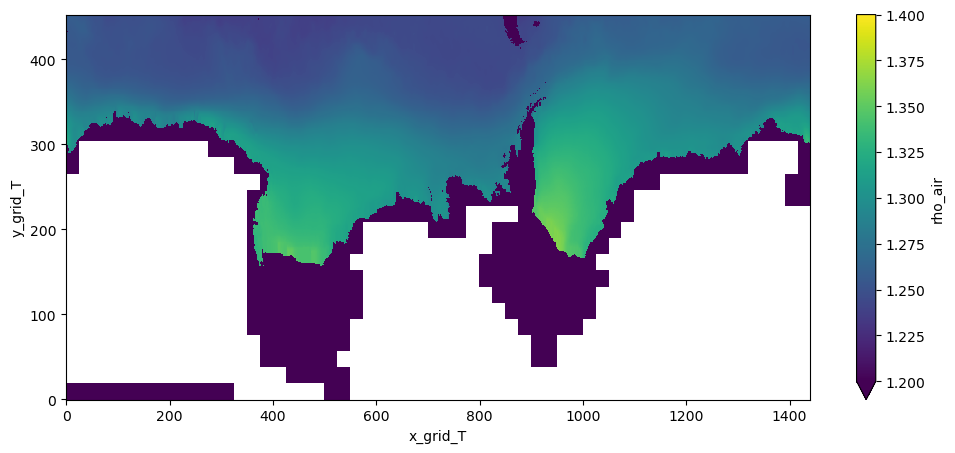

In [17]:
# Cd_oce, Cd_ice
era5_ds.Cd_oce.plot(figsize=(12,5), vmin=10e-4, vmax=20e-4)
era5_ds.Cd_ice.plot(figsize=(12,5), vmin=10e-4, vmax=20e-4)
era5_ds.rho_air.plot(figsize=(12,5), vmin=1.2, vmax=1.4)

In [35]:
# constants --- air density is more or less the same between experiments, but drag is definitely not
rho_air_cesm2 = cesm2_ds.rho_air #1.30   # kg/m3 (will be a 2d field)
Cd_cesm2      = cesm2_ds.Cd_oce #+ cesm2_ds.Cd_ice #1.6e-3  # momentum drag coefficient (will be a 2d field)
rho_air_era5  = era5_ds.rho_air #1.29    # kg/m3 (will be a 2d field)
Cd_era5       = era5_ds.Cd_oce #+ era5_ds.Cd_ice #1.22e-3 # momentum drag coefficient (will be a 2d field)

In [36]:
# if you read in stress from experiments:
stress_bias = era5_ds.taum - cesm2_ds.taum 
cesm2_stress_corrected      = cesm2_ds.taum + stress_bias
cesm2_wind_speed_corrected  = np.sqrt(cesm2_stress_corrected / (rho_air_cesm2 * Cd_cesm2)) # can't recreate ERA5_ds --> might be due to lack of coefficient var

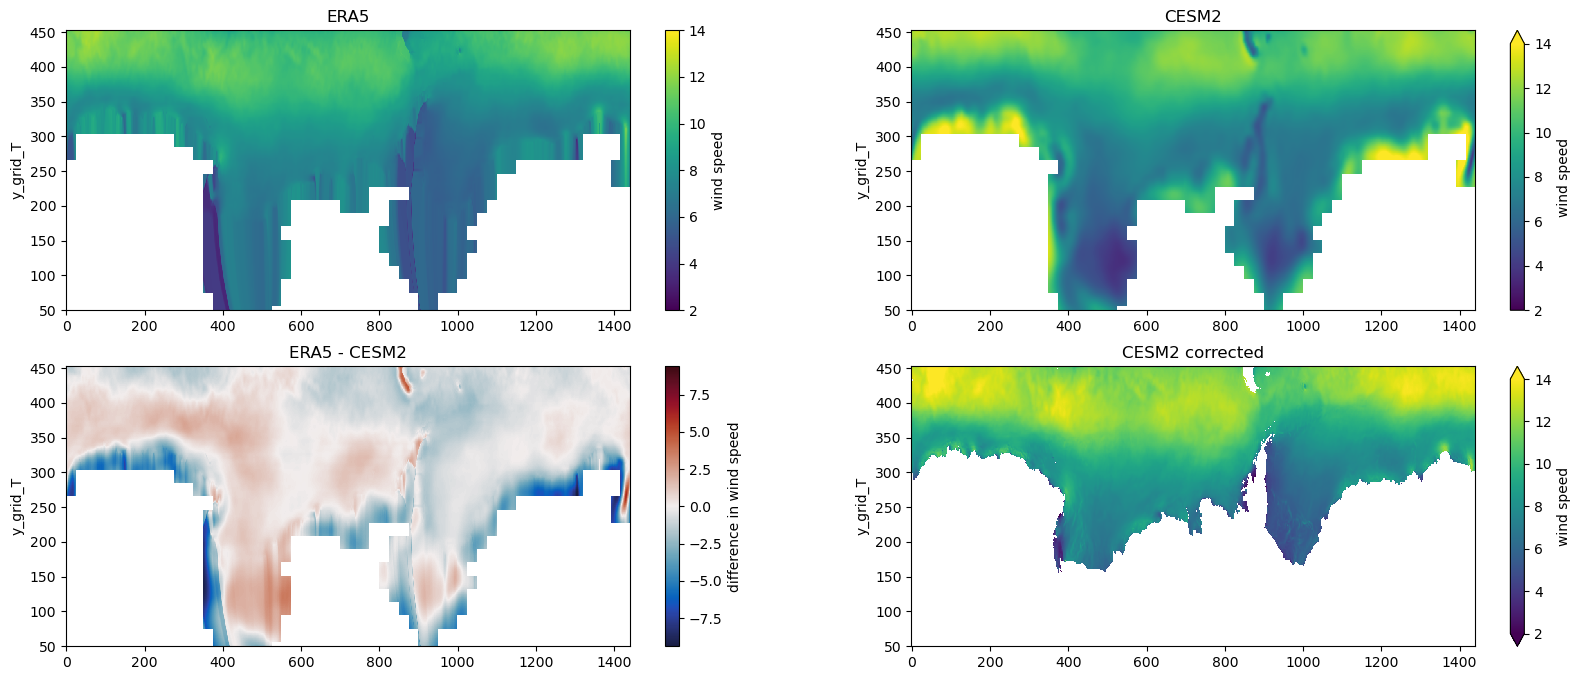

In [38]:
var = 'windsp'
kwags = {'vmin':2, 'vmax':14, 'ylim':(50,None), 'cbar_kwargs':{'label':'wind speed'}}

fig, ax = plt.subplots(2,2, figsize=(20,8))
era5_ds[var].plot(ax=ax[0,0], **kwags)
cesm2_ds[var].plot(ax=ax[0,1], **kwags)
(era5_ds[var] - cesm2_ds[var]).plot(ax=ax[1,0], cmap=cmocean.cm.balance, ylim=(50,None), cbar_kwargs={'label':'difference in wind speed'})
cesm2_wind_speed_corrected.plot(ax=ax[1,1], **kwags)
ax[0,0].set_title('ERA5'); ax[0,1].set_title('CESM2'); ax[1,0].set_title('ERA5 - CESM2'); ax[1,1].set_title('CESM2 corrected')
for axis in ax.ravel():
    axis.set_xlabel('')

In [62]:
# if you don't read in stress from experiments:
stress_era5  = rho_air_era5 * Cd_era5 * (era5_u.u10**2 + era5_v.v10**2)
stress_cesm2 = rho_air_cesm2 * Cd_cesm2 * (cesm2_u.UBOT**2 + cesm2_v.VBOT**2)

# stress_era5x = rho_air_era5 * Cd_era5 * np.sqrt(era5_u.u10**2 + era5_v.v10**2) * era5_u.u10
# stress_era5y = rho_air_era5 * Cd_era5 * np.sqrt(era5_u.u10**2 + era5_v.v10**2) * era5_v.v10

# # regrid stresses to NEMO grid
# nemo_stress_era5 = ... #
# nemo_stress_cesm2 = ... #

# # calculate stress bias
# stress_bias = nemo_stress_era5 - nemo_stress_cesm2
# cesm2_stress_corrected = nemo_stress_cesm2 + stress_bias
# cesm2_wind_speed_corrected  = np.sqrt(cesm2_stress_corrected / (rho_air_cesm2 * Cd_cesm2))  
# # then split back into u and v components based on their original angle

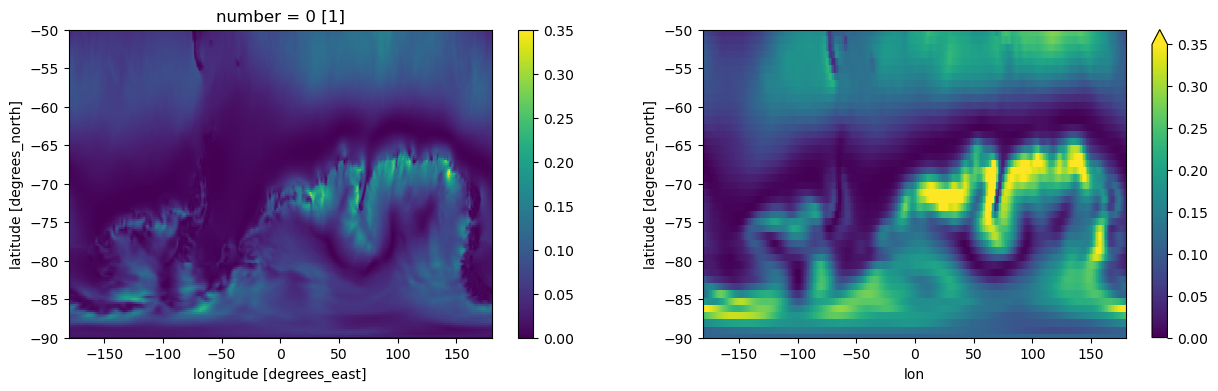

In [70]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
stress_era5.plot(ax=ax[0], ylim=(-90,-50), vmin=0, vmax=0.35)
stress_cesm2.sortby('lon').plot(ax=ax[1], ylim=(-90,-50), vmin=0, vmax=0.35)

## Visualize

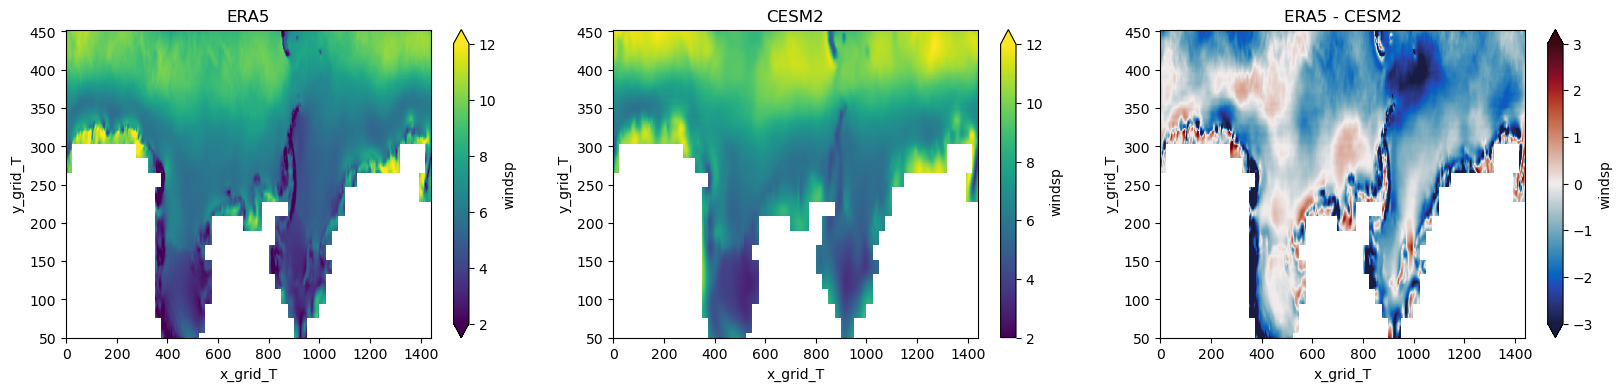

In [7]:
var = 'windsp'
kwags = {'vmin':2, 'vmax':12, 'ylim':(50,None)}

fig, ax = plt.subplots(1,3, figsize=(20,4))
cesm2era5[var].plot(ax=ax[0], **kwags)
cesm2u10[var].plot(ax=ax[1], **kwags)
(cesm2era5[var] - cesm2u10[var]).plot(ax=ax[2], cmap=cmocean.cm.balance, ylim=(50,None), vmin=-3, vmax=3)
ax[0].set_title('ERA5'); ax[1].set_title('CESM2'); ax[2].set_title('ERA5 - CESM2');

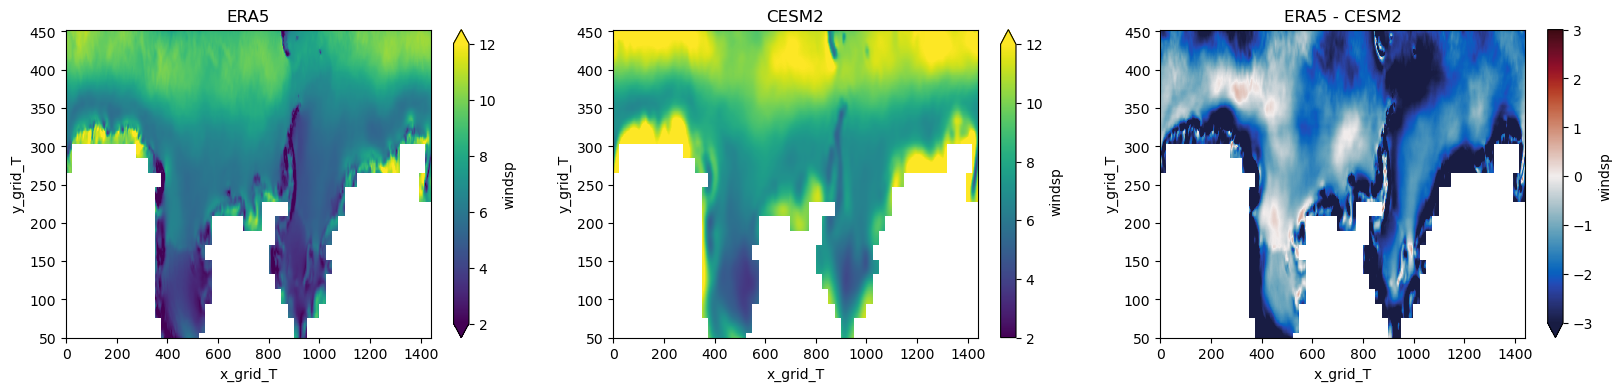

In [8]:
var = 'windsp'
kwags = {'vmin':2, 'vmax':12, 'ylim':(50,None)}

fig, ax = plt.subplots(1,3, figsize=(20,4))
cesm2era5[var].plot(ax=ax[0], **kwags)
cesm2_ds[var].plot(ax=ax[1], **kwags)
(cesm2era5[var] - cesm2_ds[var]).plot(ax=ax[2], cmap=cmocean.cm.balance, ylim=(50,None), vmin=-3, vmax=3)
ax[0].set_title('ERA5'); ax[1].set_title('CESM2'); ax[2].set_title('ERA5 - CESM2');

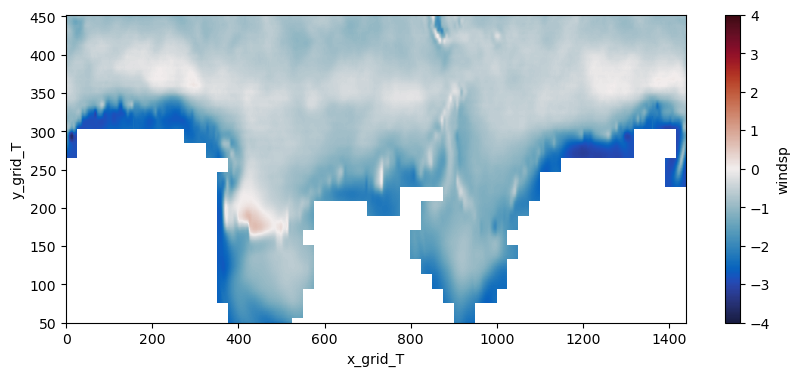

In [10]:
(cesm2u10[var] - cesm2_ds[var]).plot(figsize=(10,4), cmap=cmocean.cm.balance, ylim=(50,None), vmin=-4, vmax=4)

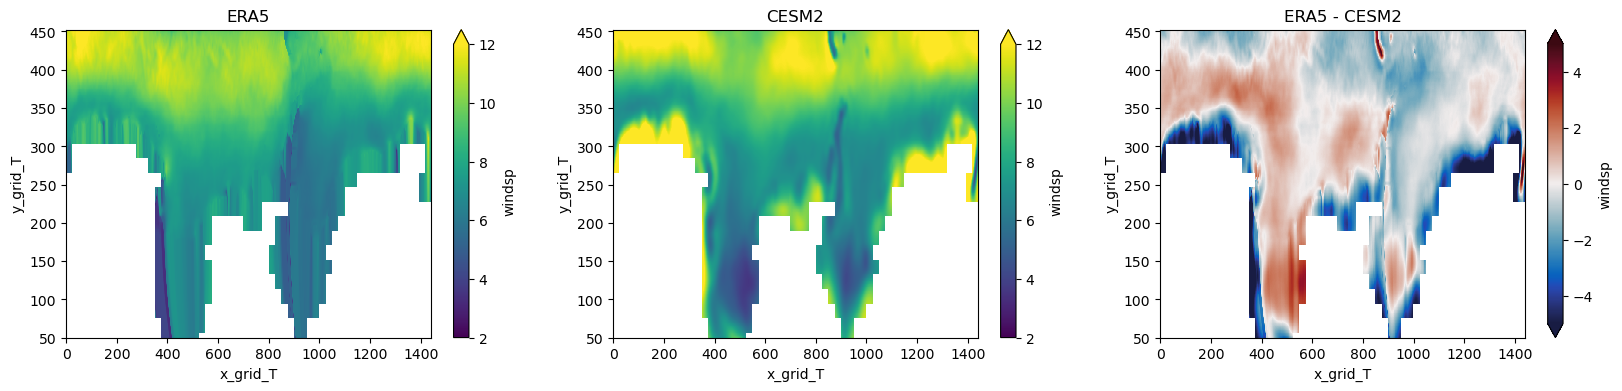

In [6]:
var = 'windsp'
kwags = {'vmin':2, 'vmax':12, 'ylim':(50,None)}

fig, ax = plt.subplots(1,3, figsize=(20,4))
era5_ds[var].plot(ax=ax[0], **kwags)
cesm2_ds[var].plot(ax=ax[1], **kwags)
(era5_ds[var] - cesm2_ds[var]).plot(ax=ax[2], cmap=cmocean.cm.balance, ylim=(50,None), vmin=-5, vmax=5)
ax[0].set_title('ERA5'); ax[1].set_title('CESM2'); ax[2].set_title('ERA5 - CESM2');

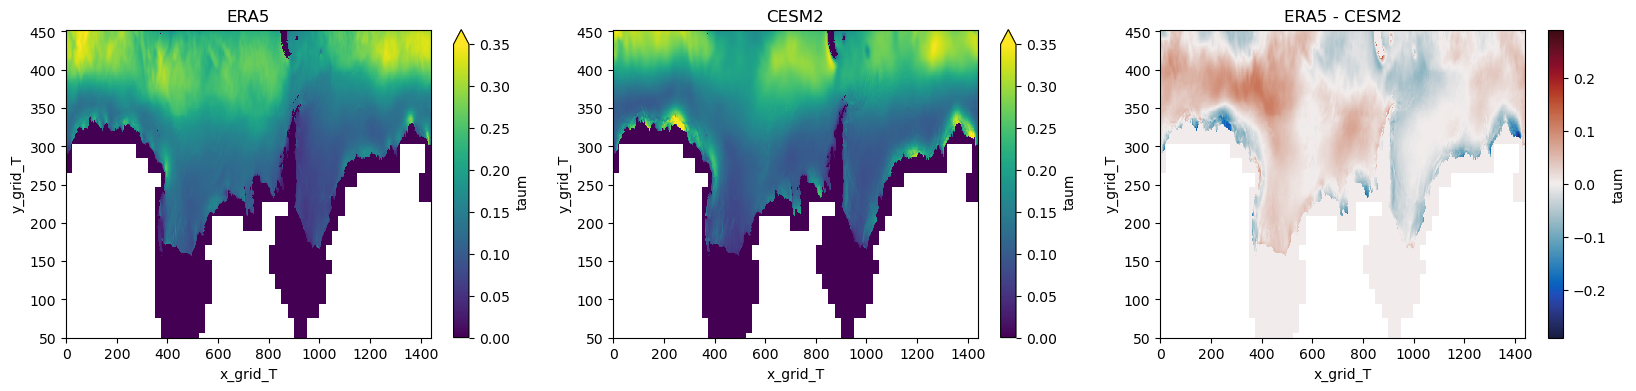

In [17]:
var = 'taum'
kwags = {'vmin':0, 'vmax':0.35, 'ylim':(50,None)}

fig, ax = plt.subplots(1,3, figsize=(20,4))
era5_ds[var].plot(ax=ax[0], **kwags)
cesm2_ds[var].plot(ax=ax[1], **kwags)
(era5_ds[var] - cesm2_ds[var]).plot(ax=ax[2], cmap=cmocean.cm.balance, ylim=(50,None))
ax[0].set_title('ERA5'); ax[1].set_title('CESM2'); ax[2].set_title('ERA5 - CESM2');